In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense, Conv1D, GlobalMaxPooling1D, Flatten, concatenate, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.metrics import Precision, Recall, Accuracy
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD

import torch
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np
import pickle

import pandas as pd

In [2]:
with open("model_proccess_data_3", "rb") as fp:   # Unpickling
    model_data = pickle.load(fp)
X_train_bart, X_test_bart, y1_train_hot, y1_test_hot, y2_train_hot, y2_test_hot, encoder1, encoder2 = model_data

with open("test_output_data_3", "rb") as fp:   # Unpickling
    test_data = pickle.load(fp)
X_train, X_test, y1_train, y1_test, y2_train, y2_test = test_data

In [3]:
print(X_train_bart.shape, X_test_bart.shape)

torch.Size([2508, 72, 1024]) torch.Size([861, 72, 1024])


In [4]:
y1_train_hot.shape

(2508, 6)

In [5]:
y2_train_hot.shape

(2508, 3)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Conv1D,MaxPooling1D, GlobalAveragePooling1D,GlobalMaxPooling1D, Dense, Dropout, Reshape, BatchNormalization
from keras.regularizers import l2

In [12]:
def my_model(X_train, X_test, y1_train, y1_test, y2_train, y2_test):
    # Define the model with two inputs
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))


    # Shared layers
    x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    x = Dropout(0.5)(x)
    x = Conv1D(filters=32, kernel_size=5, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = GlobalMaxPooling1D()(x)
    
    

    # Output layers for each set of labels
    predictions_1 = Dense(y1_train.shape[1], activation='softmax', name='output1')(x)
    predictions_2 = Dense(y2_train.shape[1], activation='softmax', name='output2')(x)

    # Create the model with two outputs
    model = Model(inputs=input_layer, outputs=[predictions_1, predictions_2])

    adam_optimizer = Adam(learning_rate=0.001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    model.compile(
        optimizer=adam_optimizer,
        loss={
            'output1': 'categorical_crossentropy',
            'output2': 'categorical_crossentropy'
        },
        metrics={
            'output1': ['accuracy', Precision(name='precision'), Recall(name='recall')],
            'output2': ['accuracy', Precision(name='precision'), Recall(name='recall')]
        }
    )

    # Fit the model
    history = model.fit(X_train, [y1_train, y2_train], epochs=200, batch_size = 32, validation_data=(X_test, [y1_test, y2_test]), 
                        callbacks=[early_stopping])


    plt.figure(figsize=(14, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['output1_accuracy'], label='Training Accuracy Output 1')
    plt.plot(history.history['val_output1_accuracy'], label='Validation Accuracy Output 1')
    plt.plot(history.history['output2_accuracy'], label='Training Accuracy Output 2')
    plt.plot(history.history['val_output2_accuracy'], label='Validation Accuracy Output 2')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Display the plot
    plt.show()

    return model

Epoch 1/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 13s 124ms/step - loss: 2.0097 - output1_accuracy: 0.5383 - output1_precision: 0.6576 - output1_recall: 0.4029 - output2_accuracy: 0.7288 - output2_precision: 0.7377 - output2_recall: 0.7002 - val_loss: 1.1828 - val_output1_accuracy: 0.8142 - val_output1_precision: 0.9415 - val_output1_recall: 0.5981 - val_output2_accuracy: 0.8850 - val_output2_precision: 0.9144 - val_output2_recall: 0.8432
Epoch 2/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 114ms/step - loss: 0.8703 - output1_accuracy: 0.8160 - output1_precision: 0.8741 - output1_recall: 0.7576 - output2_accuracy: 0.8910 - output2_precision: 0.9051 - output2_recall: 0.8761 - val_loss: 1.0298 - val_output1_accuracy: 0.8467 - val_output1_precision: 0.9451 - val_output1_recall: 0.6597 - val_output2_accuracy: 0.8885 - val_output2_precision: 0.9324 - val_output2_recall: 0.8328
Epoch 3/200
79/79 ━━━━━━━━━━━━━━━━━━━━ 9s 117ms/step - loss: 0.6335 - output1_accuracy: 0.8809 - output1_precision: 0.9084 - output1_reca

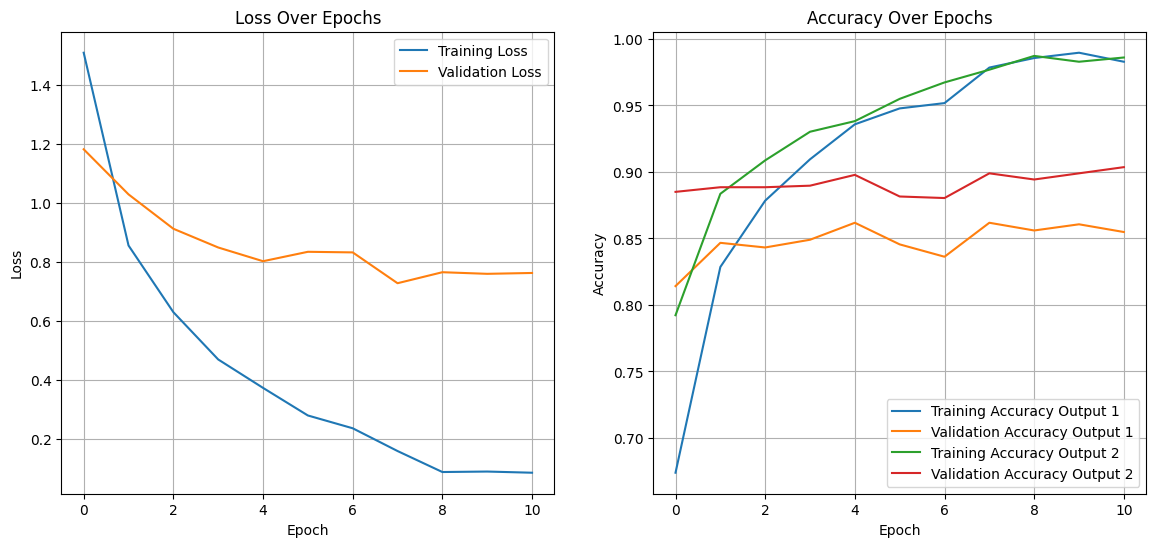

In [13]:
model = my_model(X_train_bart, X_test_bart, y1_train_hot, y1_test_hot, y2_train_hot, y2_test_hot)

In [ ]:
set(y2_train)

{'negative', 'neutral', 'positive'}

In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, X_test, y1_test_hot, y2_test_hot, encoder1, encoder2, zero_division=0):
    # Predict the outputs
    y1_pred_hot, y2_pred_hot = model.predict(X_test)
    
    # Convert one-hot predictions to labels
    y1_pred = encoder1.inverse_transform(y1_pred_hot)
    y2_pred = encoder2.inverse_transform(y2_pred_hot)
    
    y1_true = encoder1.inverse_transform(y1_test_hot)
    y2_true = encoder2.inverse_transform(y2_test_hot)
    
    # Calculate metrics for task 1
    accuracy1 = accuracy_score(y1_true, y1_pred)
    precision1 = precision_score(y1_true, y1_pred, average='weighted', zero_division=zero_division)
    recall1 = recall_score(y1_true, y1_pred, average='weighted', zero_division=zero_division)
    f1_1 = f1_score(y1_true, y1_pred, average='weighted', zero_division=zero_division)
    
    # Calculate metrics for task 2
    accuracy2 = accuracy_score(y2_true, y2_pred)
    precision2 = precision_score(y2_true, y2_pred, average='weighted', zero_division=zero_division)
    recall2 = recall_score(y2_true, y2_pred, average='weighted', zero_division=zero_division)
    f1_2 = f1_score(y2_true, y2_pred, average='weighted', zero_division=zero_division)
    
    metrics = {
        'output1': {
            'accuracy': accuracy1,
            'precision': precision1,
            'recall': recall1,
            'f1_score': f1_1
        },
        'output2': {
            'accuracy': accuracy2,
            'precision': precision2,
            'recall': recall2,
            'f1_score': f1_2
        }
    }
    
    return metrics




In [44]:
# !pip install

In [21]:
metrics = evaluate_model(model, X_test_bart, y1_test_hot, y2_test_hot, encoder1, encoder2)
metrics_df = pd.DataFrame(metrics)



metrics_df

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


,output1,output2
accuracy,0.861789,0.898955
precision,0.862748,0.891544
recall,0.861789,0.898955
f1_score,0.856383,0.889556


In [18]:
model.evaluate(X_test_bart, [y1_test_hot, y2_test_hot])

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.6534 - output1_accuracy: 0.8817 - output1_precision: 0.9010 - output1_recall: 0.8567 - output2_accuracy: 0.9053 - output2_precision: 0.9213 - output2_recall: 0.9010


[0.7285181283950806,
 0.8617886304855347,
 0.8820638656616211,
 0.833914041519165,
 0.8989546895027161,
 0.9208633303642273,
 0.891986072063446]

In [19]:
model.save('my_model_BART.keras')